# Data preprocessing
##  1. Importing the libraries and dataset

In [36]:
%run utilspro.py

## 2. Data cleaning: Handling missing values and outliers

In [24]:
# Check for missing values in train_clinical_data
missing_values = train_clinical_data.isnull().sum()
missing_values[missing_values > 0]

updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

For the UPDRS scores, we can impute the missing values with the median value since it's less sensitive to outliers. For the upd23b_clinical_state_on_medication column, since it's categorical, we can impute with the most frequent value.

In [25]:
# Impute missing values for UPDRS scores with median value
for column in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    median_value = train_clinical_data[column].median()
    train_clinical_data[column].fillna(median_value, inplace=True)

# Impute missing values for upd23b_clinical_state_on_medication with most frequent value
most_frequent_value = train_clinical_data['upd23b_clinical_state_on_medication'].mode()[0]
train_clinical_data['upd23b_clinical_state_on_medication'].fillna(most_frequent_value, inplace=True)

# Check again for missing values
missing_after_imputation = train_clinical_data.isnull().sum()

missing_after_imputation[missing_after_imputation > 0]


Series([], dtype: int64)

The missing values have been successfully imputed, and there are no more missing values in the train_clinical_data dataset.

Next, let's handle outliers. For this analysis, we'll focus on UPDRS scores, as these are our target variables.

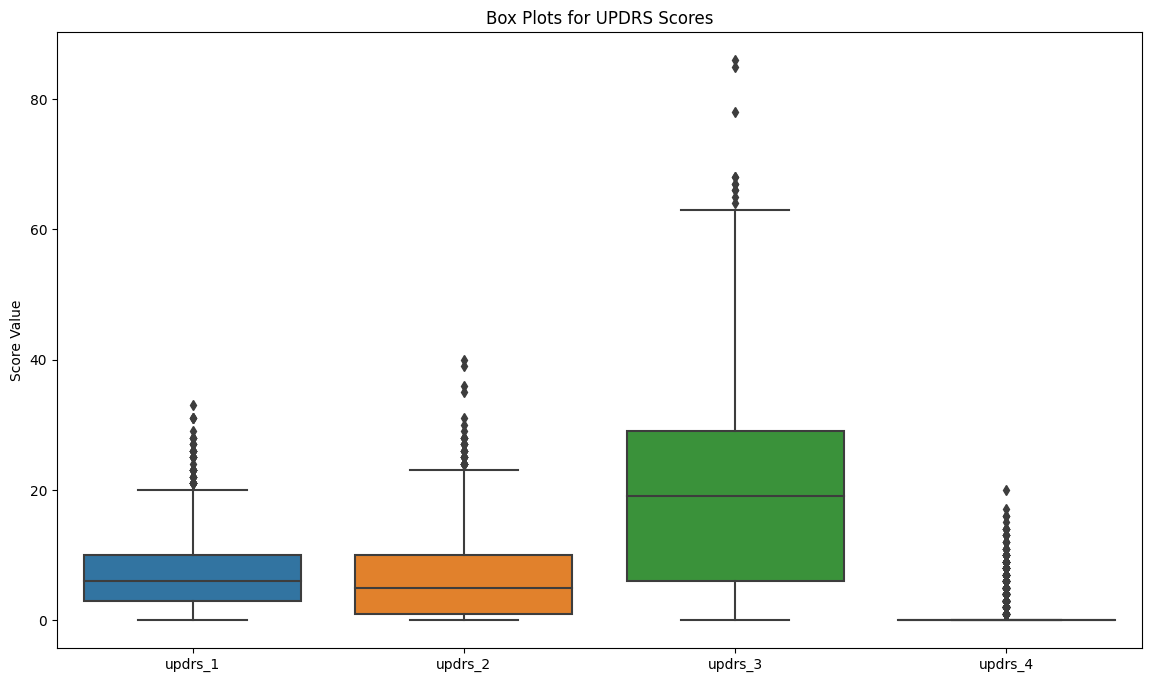

In [26]:
# Let's visualize the distribution of UPDRS scores using box plots to identify potential outliers.
# Plot box plots for UPDRS scores to visualize outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']])
plt.title('Box Plots for UPDRS Scores')
plt.ylabel('Score Value')
plt.show()

There are potential outliers, especially in updrs_3 and updrs_4.
The whiskers of the box plots can help in determining the range beyond which data points are considered outliers.

#### Detecting the outlier by IQR method

In [27]:
# Compute IQR for each UPDRS score
Q1 = data_for_outliers.quantile(0.25)
Q3 = data_for_outliers.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers based on the IQR method
outliers_iqr = ((data_for_outliers < (Q1 - 1.5 * IQR)) | (data_for_outliers > (Q3 + 1.5 * IQR))).any(axis=1)

# Number of outliers identified by IQR method
outliers_iqr.sum()


641

#### Detect outliers by Mahalanobis Distance

In [28]:
# Extract UPDRS scores for outlier detection
data_for_outliers = train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

# Compute Robust Mahalanobis Distance using Minimum Covariance Determinant (MCD) method
mcd = MinCovDet(random_state=42).fit(data_for_outliers)
robust_mahalanobis_distance = mcd.mahalanobis(data_for_outliers)

# Choose a threshold (e.g., based on chi-squared distribution with df equal to number of features)
from scipy.stats import chi2
threshold_rmd = chi2.ppf((1 - 0.01), df=data_for_outliers.shape[1])  # 99% confidence

# Identify outliers based on the threshold
outliers_rmd = np.where(robust_mahalanobis_distance > threshold_rmd)

# Number of outliers identified by Robust Mahalanobis Distance
len(outliers_rmd[0])


328

In [30]:
#### Comparing the results of the two methods
# Overlap analysis
outliers_rmd_set = set(outliers_rmd[0])
outliers_iqr_set = set(outliers_iqr[outliers_iqr].index)

# Outliers identified by both methods
common_outliers = outliers_rmd_set.intersection(outliers_iqr_set)

# Outliers identified only by Robust Mahalanobis Distance
only_rmd_outliers = outliers_rmd_set - outliers_iqr_set

# Outliers identified only by IQR method
only_iqr_outliers = outliers_iqr_set - outliers_rmd_set

len(common_outliers), len(only_rmd_outliers), len(only_iqr_outliers)

(205, 123, 436)

* 205 data points are identified as outliers by both methods.
* 123 data points are identified as outliers only by the Robust Mahalanobis Distance method.
* 436 data points are identified as outliers only by the IQR method.
##### Analysis of Potential Data Loss:
If we were to remove the outliers identified by the IQR method (as it identified the most outliers), we'd lose 641 data points, 24.51% of the dataset. This is a significant proportion and could impact the predictive power of the model, especially if some of the removed data points contain crucial information

In [31]:
# remove outliers using robust mahalanobis distance
train_clinical_data = train_clinical_data.drop(index=only_rmd_outliers) # remove outliers identified by RMD

In [35]:
train_clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2492 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2492 non-null   object 
 1   patient_id                           2492 non-null   int64  
 2   visit_month                          2492 non-null   int64  
 3   updrs_1                              2492 non-null   float64
 4   updrs_2                              2492 non-null   float64
 5   updrs_3                              2492 non-null   float64
 6   updrs_4                              2492 non-null   float64
 7   upd23b_clinical_state_on_medication  2492 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 175.2+ KB


## 3.  Encoding, Feature Scaling, and Splitting the data 

In [38]:
# One-hot encoding for the categorical feature
encoded_features = pd.get_dummies(train_clinical_data['upd23b_clinical_state_on_medication'], prefix='medication')

# Combine the UPDRS scores and encoded features
X = pd.concat([train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], encoded_features], axis=1)

# Separate the target variable (we'll predict UPDRS Part 3 for this analysis)
y = X.pop('updrs_3')

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((2092, 5), (523, 5))

The data has been successfully scaled and encoded. The training set contains 2,092 samples, while the test set contains 523 samples. Each sample has 5 features: updrs_1, updrs_2, updrs_4, and two one-hot encoded features for upd23b_clinical_state_on_medication